# SENTIMENT ANALYSIS OF DISTROWATCH REVIEWS.

## Part 2: NLP and supervised classification

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Colab_Notebooks/distrowatch NLP

/content/drive/MyDrive/Colab_Notebooks/distrowatch NLP


In [3]:
import re
from pickle import load

import numpy as np
import pandas as pd
# import exploretext

import matplotlib.pyplot as plt
from yellowbrick.target import ClassBalance
from yellowbrick.text import FreqDistVisualizer
from yellowbrick.classifier import ConfusionMatrix,ClassPredictionError

from nltk import download
# from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
download('stopwords',quiet=True)

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import ComplementNB,MultinomialNB
from sklearn import metrics

## Import data and perform basic exploration

Data splitting is usually one of the first steps we need to make but in this case we'll leave it for later since there is no risk of data leakage (I think)

In [4]:
df = pd.read_csv('distrowatch.csv',index_col=0,lineterminator='\n') # https://stackoverflow.com/questions/33998740/error-in-reading-a-csv-file-in-pandascparsererror-error-tokenizing-data-c-err

print('Missing values')
print(df.isna().sum(),'\n')

print('Duplicates')
print(df.duplicated().sum(),'\n')

print('Basic info')
df.info()

Missing values
date       0
project    0
version    0
rating     0
votes      0
review     0
dtype: int64 

Duplicates
0 

Basic info
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4014 entries, 0 to 4013
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     4014 non-null   object
 1   project  4014 non-null   object
 2   version  4014 non-null   object
 3   rating   4014 non-null   int64 
 4   votes    4014 non-null   int64 
 5   review   4014 non-null   object
dtypes: int64(2), object(4)
memory usage: 219.5+ KB


### Target distribution

Visualizing our target distribution is crucial, among other things we need to determine if there exists class imbalance

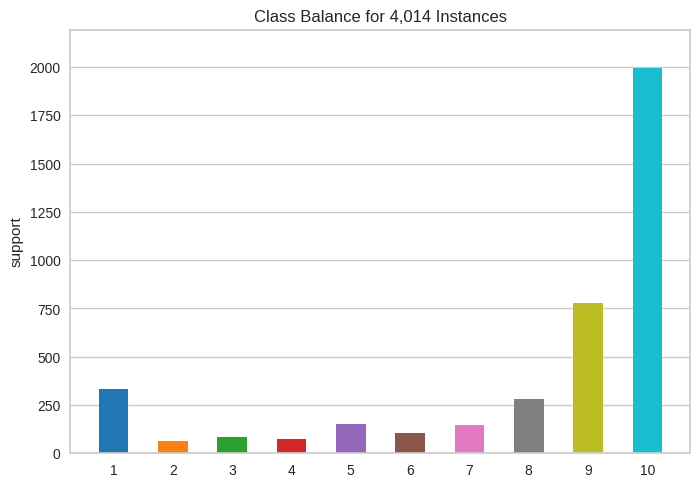

<Axes: title={'center': 'Class Balance for 4,014 Instances'}, ylabel='support'>

In [5]:
viz = ClassBalance(colormap='tab10')
viz.fit(df['rating'])
viz.show()

As it often happens with ratings, the distribution is skewed, which results in severe class imbalance. It seems that people tend to express their opinion about a distro especially when the opinion is extreme. In the modelling phase we'll fit a model using this "raw" target variable, but it's also worth exploring alternative encodings we could get by grouping ratings.

From a psychological point of view, we could defend the idea that ratings are (pseudo)continuous variables, there is a continuum that goes from 1 (terrible distro) to 10 (excellent distro) (or other scale) and captures different nuanced sentiments. But we could also argue that ratings really represent a few psychological states or sentiments: negative, neutral and positive, for example. And the scores given in the survey lie in one of those groups, the exact quantity is not very relevant.

In the next cell I've created different (more or less) reasonable groups, based on some reviews I've read.

% of each category
[6, 10]    82.361734
[1, 5]     17.638266
Name: rating, dtype: float64 

% of each category
[8, 10]    76.058794
[1, 4]     13.801694
[5, 7]     10.139512
Name: rating, dtype: float64 

% of each category
[9, 10]    69.083209
[1, 5]     17.638266
[6, 8]     13.278525
Name: rating, dtype: float64 



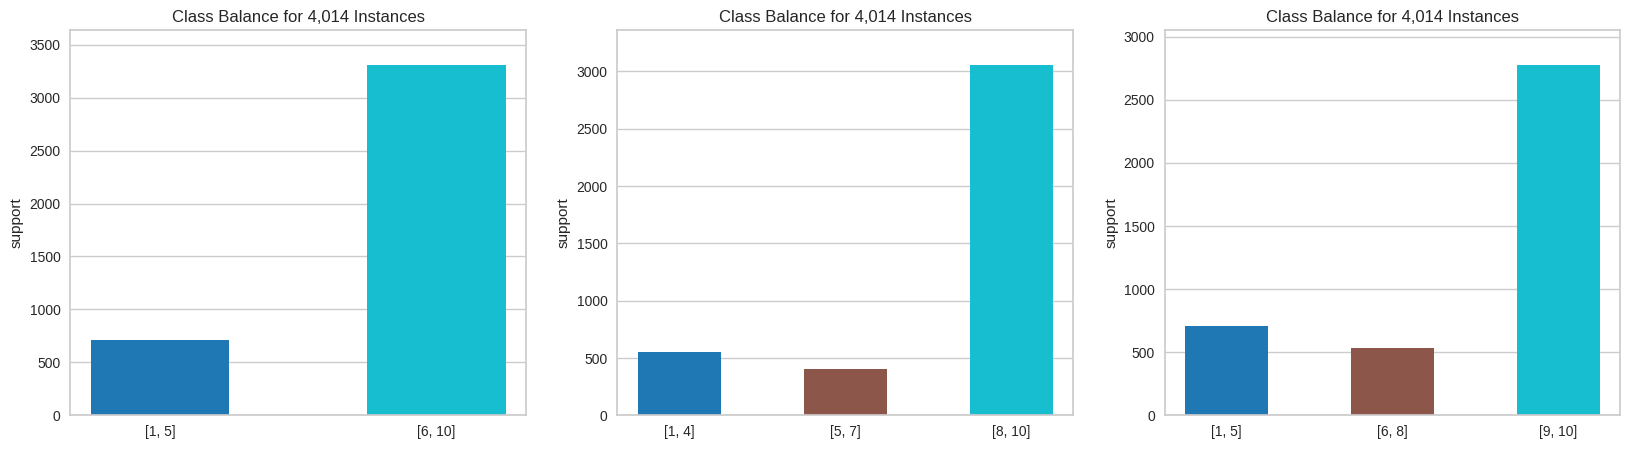

In [6]:
cats = [
    [(1, 5), (6, 10)], # binary situation: neg vs pos
    [(1, 4), (5, 7), (8, 10)], # neg vs neut vs pos
    [(1, 5), (6, 8), (9, 10)] # neg vs neut vs pos
]

fig,ax = plt.subplots(nrows=1,ncols=3,figsize=[20,5])
for i,bin in enumerate(cats):
  rating_cat = pd.cut(df.rating,bins=pd.IntervalIndex.from_tuples(cats[i],closed='both'))
  print('% of each category')
  print(rating_cat.value_counts(normalize=True)*100,'\n')
  viz = ClassBalance(ax=ax[i],colormap='tab10')
  viz.fit(rating_cat.astype(str))
  viz.finalize()

None of the groupings eliminates de class imbalance problem, but the second and third options alleviate it a little.

We'll create new dependent variables and use them later

In [7]:
df['rating_cat1'] = pd.cut(df.rating,bins=pd.IntervalIndex.from_tuples([(1, 5), (6, 10)],closed='both')).astype(str)
df['rating_cat2'] = pd.cut(df.rating,bins=pd.IntervalIndex.from_tuples([(1, 4), (5, 7), (8, 10)],closed='both')).astype(str)
df['rating_cat3'] = pd.cut(df.rating,bins=pd.IntervalIndex.from_tuples([(1, 5), (6, 8), (9, 10)],closed='both')).astype(str)

## Text pre-processing

After some brief data exploration, we can now start thinking about how to text processing

### Tokenization

First we're going to transform the reviews into word tokens. Because we're dealing with a task of sentiment analysis, we'll include some custom transformations that may be useful:

* Respect words written in uppercase → more emphasis (?)
* Include explicit ratings used in the text reviews e.g.: "8/10"

Finally, because in this context people is reviewing linux distributions, we may want to remove digits (they usually refer to software versions)

In [8]:

def preproc_tokenize(review):
  text_rating = re.findall(r'\d\/10',review)
  review_modif = re.sub(r'(\b[A-Z]{4,}\b)',r'upperc\1',review)
  review_modif = re.sub(r'\d+\.?','',review_modif)
  tokens = re.findall(r'(?u)\b\w\w+\b|[!|?]',review_modif.lower()) + text_rating
  # stemmed_tokens = [SnowballStemmer('english').stem(w) for w in tokens]
  return tokens

ex = 'xdistrox version 2.04 is a great distro! 8/10. It works in my OS VERY nicely. Why nobody is talking about it??'

print(ex)
print(preproc_tokenize(ex))

xdistrox version 2.04 is a great distro! 8/10. It works in my OS VERY nicely. Why nobody is talking about it??
['xdistrox', 'version', 'is', 'great', 'distro', '!', 'it', 'works', 'in', 'my', 'os', 'uppercvery', 'nicely', 'why', 'nobody', 'is', 'talking', 'about', 'it', '?', '?', '8/10']


Note that we haven't applied stemming nor lemmatization. It's common to use these techniques, but I've decided not to use them mainly because the vocabulary is not very big as it is.

Also, to be honest, after a few tests with cross validation I've seen that stemming doesn't seem to improve performance

### Stop words



Some words may not be discriminative in this context like "OS", "distro", "version", the name of the distribution... We'll remove this stop words to reduce the number of features.

However, we'll keep some words like "very" or "most", because they can be useful when expessing emotions (if we allow bigrams to be present), e.g.: very frustrating, most promising...

In [9]:
to_keep = ['all','any','both','each','few','most','more','only','too','very'] # not
stop = [w for w in stopwords.words('english') if w not in to_keep]

extra_stop = ['OS','distro','LTS','version','Linux','USB','PC']

# names were obtained from distrowatch.com using web scraping, see notebook for part 1
with open("distro_names", "rb") as f:
  distro_names = load(f)

stop.extend(extra_stop)
stop.extend(distro_names)

# stopwords need to be processed as any other token
stop_tokens = preproc_tokenize(' '.join(stop))

### Vectorization

There are multiple ways of representing the tokens as numeric vectors. One of the simplest approaches is the bag of words approach. This model imposes several restrictions (word ordering is not considered) but works well in many cases.

Before starting the process of vectorization we'll proceed to split the data

In [10]:
# 80% train 20% test
train_ids,test_ids = train_test_split(np.arange(df.shape[0]),
                                      test_size=0.2,stratify=df['rating'],
                                      random_state=66)
corpus_train = df.loc[train_ids,'review']
corpus_test = df.loc[test_ids,'review']

In [11]:
# Our Bag of Words vectorizer
bow_vectorizer = CountVectorizer(
    lowercase=False, # transformation to lowercase is done in preproc_tokenize
    tokenizer=preproc_tokenize, # custom preprocessing and tokenizing function
    stop_words=stop_tokens, # custom set of stop words
    token_pattern=None, # ignore, preproc_tokenize takes care
    ngram_range=(1,2), # unigrams and bigrams
    analyzer='word',
    max_df=0.8,
    min_df=20 # tokens have to appear at least in 20 documents -> this reduces the number of features drastically
)

Now we can plot the token distributions

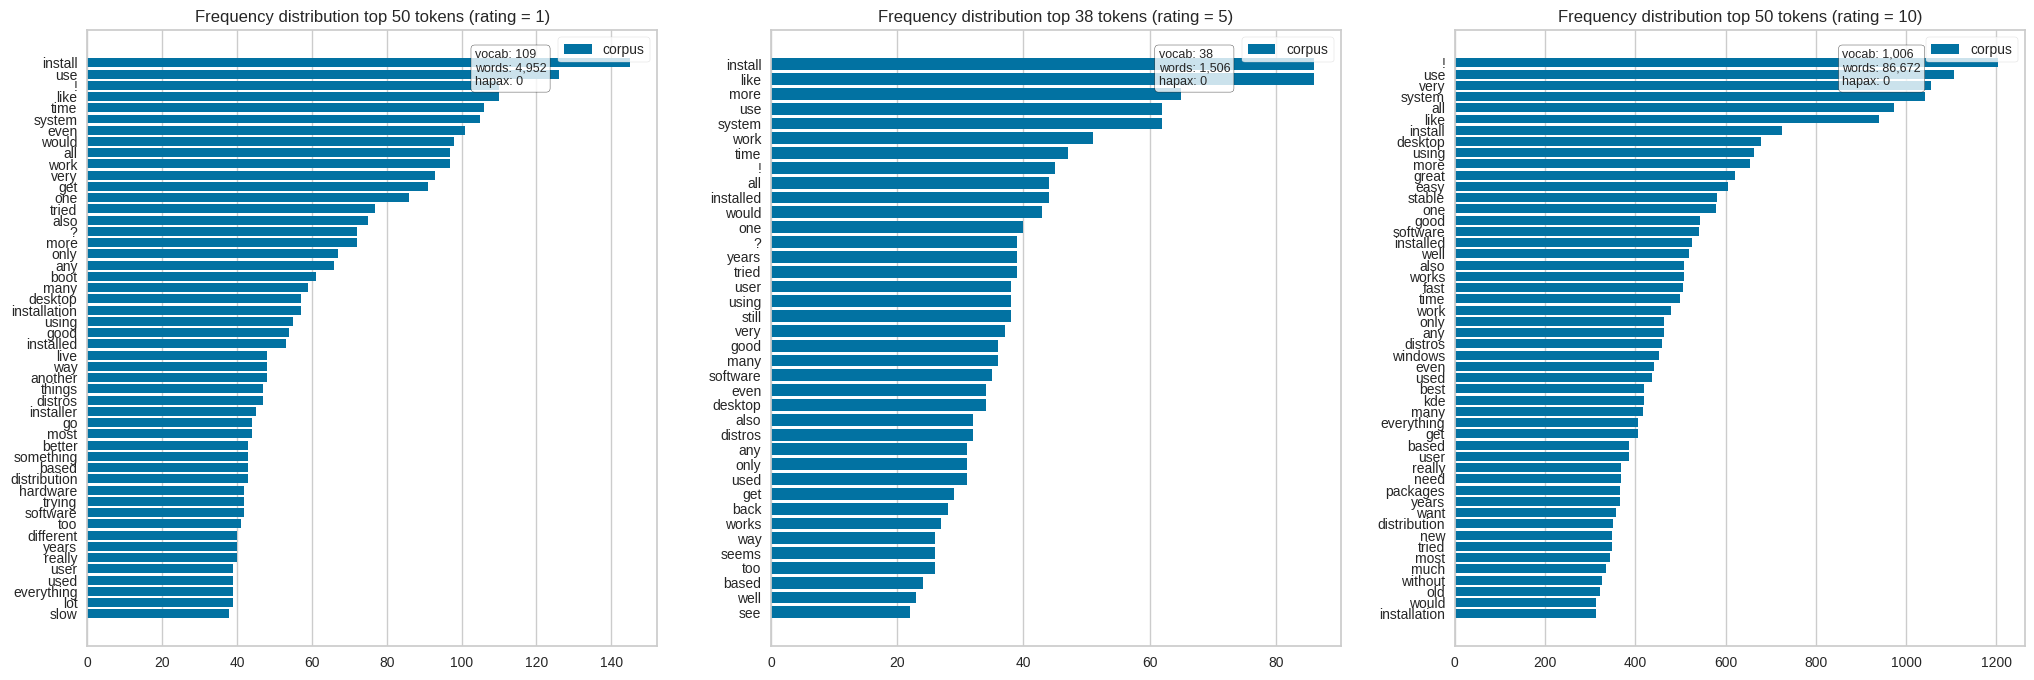

In [12]:
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=[25,8])
for i,rating in zip([0,1,2],[1,5,10]):
  docs = bow_vectorizer.fit_transform(corpus_train[df['rating'] == rating])
  features = bow_vectorizer.get_feature_names_out()
  n_tokens = min(50,len(features))
  viz = FreqDistVisualizer(ax=ax[i],features=features, n=n_tokens,
                           orient='h',
                           title=f'Frequency distribution top {n_tokens} tokens (rating = {rating})')
  viz.fit(docs)
  viz.finalize()


The distributions are not very different, but there are some interesting patterns. For example, the most frequent token in reviews with a score of 10 is the exclamation mark. People are very effusive when expressing how much they like the distribution (?)



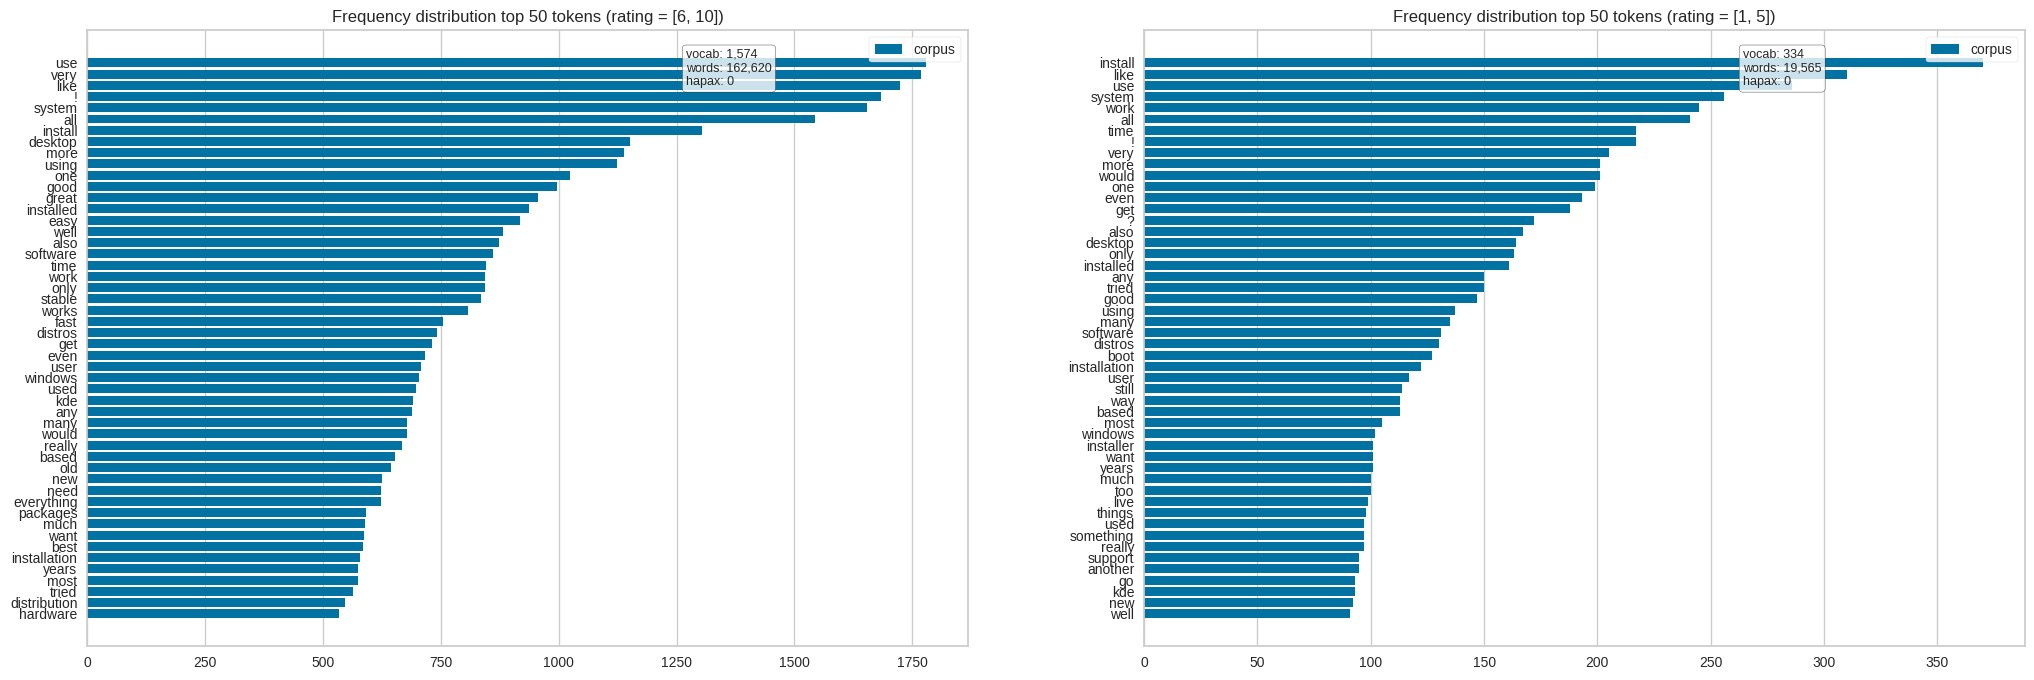

In [13]:
# binary case
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=[25,8])
for i,rating in zip([0,1],df['rating_cat1'].unique()):
  docs = bow_vectorizer.fit_transform(corpus_train[df['rating_cat1'] == rating])
  features = bow_vectorizer.get_feature_names_out()
  n_tokens = min(50,len(features))
  viz = FreqDistVisualizer(ax=ax[i],features=features, orient='h',
                           n=n_tokens,
                           title=f'Frequency distribution top {n_tokens} tokens (rating = {rating})')
  viz.fit(docs)
  viz.finalize()

Again, we don't very apparent differences, but there are some interesting things. Reviews with a score in [6,10] (positive) include tokens like "good", "easy", "stable", "works" or "fast". It clearly says a lot about what people care about and find more pleasant when using a linux distribution.

On the other hand, negative reviews contain a lot of words referring to the process of installation: "install", "installation", "installer", "boot". Many tokens are also present in the positive reviews, but others like the interrogation mark or the word "support" seem to be more frequent in negative reviews, which also tells us a lot about the data

## Build and train model(s)

There are multiple algorithms we could use to classify documents, but I'll stick with naïve Bayes. It's simple, it's fast and it doesn't have hyperparameters.

classification rule: $\hat c=\underset{c\in K}{\operatorname{argmax}} P(c)\prod_{i=1}^{|V|} P(w_i|c)$

Where $c$ represents each of the $k$ classes, $w_i$ is the ith token of the vocabulary set $V$, with size $|V|$

We'll try the basic version, Multinomial Naïve Bayes Classifier, and the Complement Naïve Bayes Classifier, which is something like a improved version of Multinomial NB.

Using cross validation, we'll test how well they perform with different encondings of the ratings. Because we have imbalanced classes, accuracy isn't very trustworthy, so the metric we're going to use for model selection will be balanced accuracy

In [14]:
# transformed data
bow_mat_train = bow_vectorizer.fit_transform(corpus_train)
print(f'n features (train):{bow_mat_train.shape[1]}')

for target in ['rating','rating_cat1','rating_cat2','rating_cat3']:
  ytrain = df.loc[train_ids,target]
  for name,model in {'MNB':MultinomialNB(),'CNB':ComplementNB()}.items():
    cv = cross_val_score(
        model,
        bow_mat_train,
        ytrain,
        scoring='balanced_accuracy',
        cv=5,
        n_jobs=-1
    )
    print(target,'-',name)
    print(f'5-CV balanced accuracy mean:{cv.mean():.3f}')
    print('---')
  print('')

n features (train):1829
rating - MNB
5-CV balanced accuracy mean:0.190
---
rating - CNB
5-CV balanced accuracy mean:0.185
---

rating_cat1 - MNB
5-CV balanced accuracy mean:0.801
---
rating_cat1 - CNB
5-CV balanced accuracy mean:0.813
---

rating_cat2 - MNB
5-CV balanced accuracy mean:0.569
---
rating_cat2 - CNB
5-CV balanced accuracy mean:0.580
---

rating_cat3 - MNB
5-CV balanced accuracy mean:0.580
---
rating_cat3 - CNB
5-CV balanced accuracy mean:0.586
---



Complement Naïve Bayes (CNB) outperforms Multinomial Naïve Bayes (MNB) on every condition and the binary enconding of the target variable is the one that works best. For that reason, we'll choose CNB as final model and we'll treat the binary enconding of the rating as our target

In [15]:
def fit_eval(model,corpus_train,corpus_test,ytrain,ytest,k=1):

  """
  Function for assessing model performance
  """

  model.fit(corpus_train,ytrain)
  preds = model.predict(corpus_test)

  global_acc = metrics.accuracy_score(ytest,preds)
  bal_acc = metrics.balanced_accuracy_score(ytest,preds)
  if k > 1:
    probs = model.predict_proba(corpus_test)
    topk = metrics.top_k_accuracy_score(ytest,probs,k=k)
    print(f'Top {k} accuracy:{topk:.3f}')
  print(f'Global accuracy:{global_acc:.3f}')
  print(f'Balanced accuracy:{bal_acc:.3f}')

  confmat = ConfusionMatrix(model,percent=True,is_fitted=True,cmap='Blues')
  confmat.fit(corpus_train,ytrain)
  confmat.score(corpus_test,ytest)
  confmat.show()

  return None


Global accuracy:0.867
Balanced accuracy:0.850


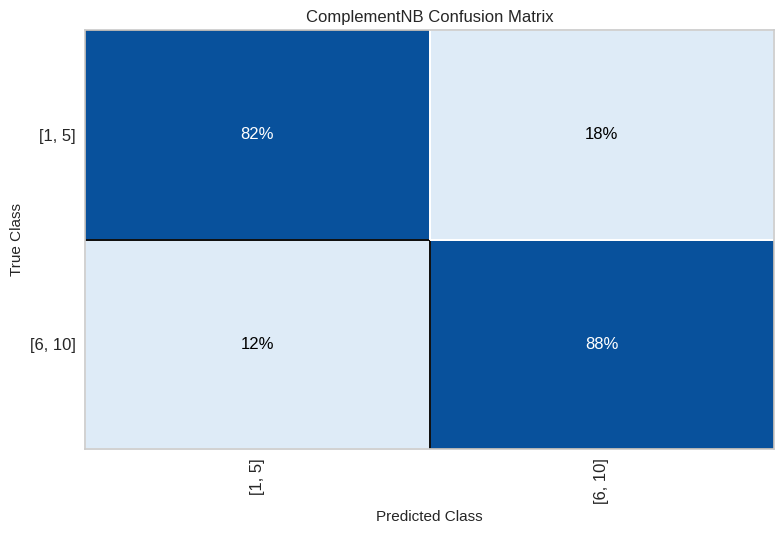

In [16]:
ytrain = df.loc[train_ids,'rating_cat1']
ytest = df.loc[test_ids,'rating_cat1']

final_model = Pipeline([
    ('vectorizer',bow_vectorizer),
    ('clf',ComplementNB())
])

fit_eval(final_model,corpus_train,corpus_test,ytrain,ytest)

Our classifier works fine and there are no clear signs of overfitting. "Negative" reviews (rating ∈ [1,5]) are more difficult to classify. In fact, 21% of negative reviews are predicted as positive. Despite that, the balanced accuracy is very good

We can also show which tokens are more relevant for the classification using log probabilities. Remember that the probability of a class is given by the review $d$ is

$P(c|d)=P(c)\prod_{i=1}^{|V_d|} P(w_i|c)$

$w_i$ now represents the tokens present in review $d$ with vocabulary $V_d$, a subset of $W$

If we take the log:

$\log P(c|d)=\log P(c)+\sum_{i=1}^{|V_d|} \log P(w_i|c)$

It's easier to see now that, as happens with linear regression, the bigger the value of $\log P(w_i|c)$, the greater importance the token $w_i$ has for predictions

In [17]:
top_tokens = 15
neg_prob_sorted = final_model['clf'].feature_log_prob_[0, :].argsort()[::-1]
pos_prob_sorted = final_model['clf'].feature_log_prob_[1, :].argsort()[::-1]

print('negative reviews')
print(np.take(final_model['vectorizer'].get_feature_names_out(), neg_prob_sorted[:top_tokens]),'\n')

print('positive reviews')
print(np.take(final_model['vectorizer'].get_feature_names_out(), pos_prob_sorted[:top_tokens]))

negative reviews
['worst' 'sad' 'terrible' 'tried install' 'way too' 'shame' 'asks'
 'asking' 'pass' 'previous versions' 'problematic' 'tries' 'failure'
 'parts' 'get things'] 

positive reviews
['configurable' 'pleased' 'charm' 'well done' 'snapshots' 'upgraded'
 'intel core' 'enjoying' 'unix' 'underrated' 'impressive' 'period'
 'most stable' 'much easier' 'favourite']


Very revealing indeed. For example, when a user mentions problems with the installation process or mentions previous versions of the software, the review is probably going to be negative. On the other hand, comments about how configurable and stable is the linux distribution predict positive reviews

I was curious about the situation where the classifier had to distinguish between all the classes available and I decided to fit a model with the original target variable

Top 3 accuracy:0.696
Global accuracy:0.502
Balanced accuracy:0.195


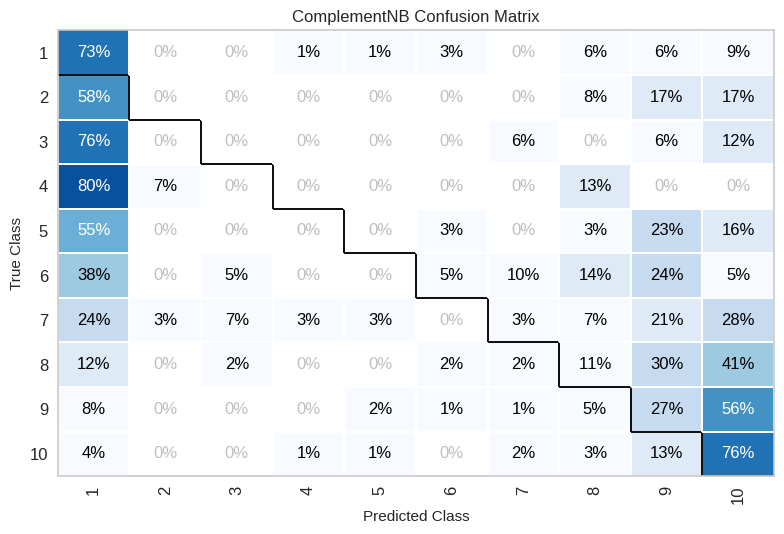

In [18]:
ytrain = df.loc[train_ids,'rating']
ytest = df.loc[test_ids,'rating']

model_allclasses = Pipeline([
    ('vectorizer',bow_vectorizer),
    ('clf',ComplementNB())
])

fit_eval(model_allclasses,corpus_train,corpus_test,ytrain,ytest,k=3)

Performance is poor in general, but if we attend to top-3 accuracy we see that the model is not awful. The thing is that the classifier can discriminate extreme reviews (1 or 10) but it struggles with reviews with close ratings. For example, 58% of observations with score of 2 are classified as 1, 76% of reviews with rating of 3 are predicted again as 1, and 80% (80!) of reviews with a 4 are treated as 1. A similar situation happens with high scores (7,8 and 9), many of them are classified as 10.

This circumstance gives some support of the idea that a dichotomic target representing positive and negative reviews may be more suitable

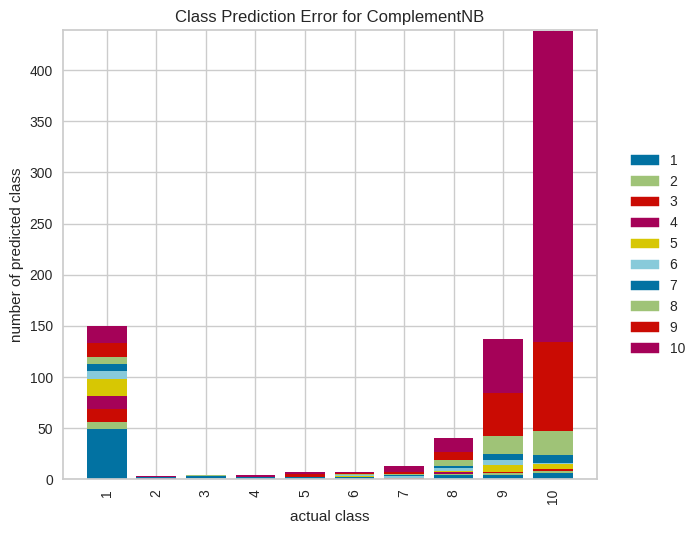

<Axes: title={'center': 'Class Prediction Error for ComplementNB'}, xlabel='actual class', ylabel='number of predicted class'>

In [19]:
# another plot to support the previous idea

class_pred_error = ClassPredictionError(model_allclasses,is_fitted=True)
class_pred_error.fit(corpus_train,ytrain)
class_pred_error.score(corpus_test,ytest)
class_pred_error.show()

## What if we consider order?

So far we have been considering the problem as a multiclass classification task, but we have overlooked an important issue. In terms of the measurement scale, the dependent variable is of ordinal type. Of a review with a score of 8 we can say not only that it is different from a review with a rating of 6, we can also say that it has a higher score. To take this circumstance into account, we can use appropriate models such as ordinal regression, but on this occasion I've preferred to adopt the approach proposed in [Frank & Hall (2001)](https://www.cs.waikato.ac.nz/~eibe/pubs/ordinal_tech_report.pdf)

The advantage is that we can use any classifier we want, so we can continue with our Naïve Bayes model. The idea is to create $k-1$ dummy targets, where $k$ is the number of classes. Each dummy variable encodes whether the rating is bigger than $c$, with $c$ being each of the $k-1$ classes. Then we fit one model for each dummy target.
To get probabaility estimates for the classes we do the following:

$P(y=1)=1-P(y>1)$

$P(y=c)=P(y>c-1)-P(y>c), \; 1<c<k$

$P(y=k)=P(y>k-1)$

In [20]:
for c in range(1,10):
  df['rating >' + str(c)] = (df['rating'] > c).astype(int)

df[[col for col in df.columns if '>' in col or col == 'rating']].sample(5)

,rating,rating >1,rating >2,rating >3,rating >4,rating >5,rating >6,rating >7,rating >8,rating >9
2691,9,1,1,1,1,1,1,1,1,0
1255,9,1,1,1,1,1,1,1,1,0
3793,4,1,1,1,0,0,0,0,0,0
3162,10,1,1,1,1,1,1,1,1,1
2680,10,1,1,1,1,1,1,1,1,1


In [21]:
nclasses = 10
dummy_targets = [col for col in df.columns if '>' in col]
Ytrain = df.loc[train_ids,dummy_targets] # matrix (dataframe) of dummy targets
prob_greater_than = np.zeros((corpus_test.shape[0],10-1))
probs = np.zeros((corpus_test.shape[0],10))

for c in range(1,nclasses): # 1 - 9
  dummy_target = 'rating >'+str(c)
  model = Pipeline([
    ('vectorizer',bow_vectorizer),
    ('clf',ComplementNB())
  ])
  model.fit(corpus_train,Ytrain[dummy_target])
  prob_greater_than[:,c-1] = model.predict_proba(corpus_test)[:,1]

probs[:,0] = 1 - prob_greater_than[:,0] # pr(y = 1) = 1 - pr(t > 1)
for c in range(1,nclasses-1):
  probs[:,c] = prob_greater_than[:,c-1] - prob_greater_than[:,c] # pr(y = c) = pr(y > c-1) - pr(y > c)
probs[:,nclasses-1] = prob_greater_than[:,nclasses-2] # pr(y = 10) = pr(y > 9)

preds = np.argmax(probs,axis=1) + 1

Global accuracy:0.487
Balanced accuracy:0.200


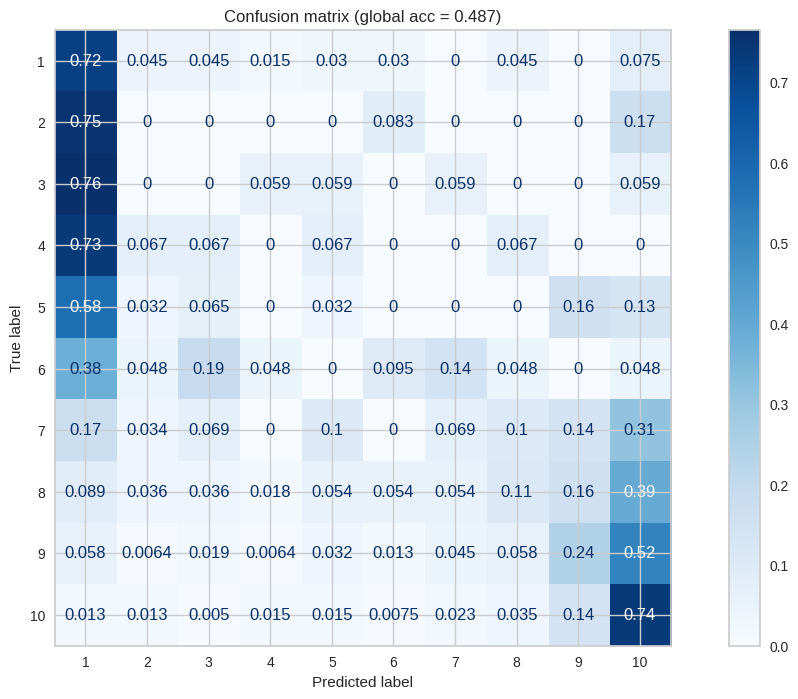

In [22]:
global_acc = metrics.accuracy_score(ytest,preds)
bal_acc = metrics.balanced_accuracy_score(ytest,preds)
# topk = metrics.top_k_accuracy_score(ytest,probs,k=k)
# print(f'Top {k} accuracy:{topk:.3f}')
print(f'Global accuracy:{global_acc:.3f}')
print(f'Balanced accuracy:{bal_acc:.3f}')

fig,ax = plt.subplots(figsize=(15,8))

metrics.ConfusionMatrixDisplay.from_predictions(ytest,preds,
                                                normalize='true',
                                                cmap='Blues', # Blues RdYlGn
                                                ax=ax)
ax.set_title(f'Confusion matrix (global acc = {global_acc:.3f})');

Well, to be honest, that was a bit disappointing. I expected this method to work better, but it only improved balanced accuracy slightly.

After having tried different strategies and seeing the results, we may ask ourselves, to what extent can we trust the coding of the dependent variable? The original variable seems not to be completely appropriate and a binary coding seems to produce more promising results (positive sentiment vs. negative sentiment), but the way it has been constructed has been relatively arbitrary. What if we do not assume the given value of the labels, the scores of the reviews, and approach the labeling problem as an unsupervised learning task? Perhaps a classification model would benefit from having constructed labels using some unsupervised algorithm.

We'll leave that for **part 3**...